<h1 align="center">Sentiment Analysis of Music Lyrics Using NLP Techniques</h1>

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import warnings
warnings.filterwarnings('ignore')

## 2. Load Dataset

In [2]:
songs_df = pd.read_csv('/kaggle/input/musicoset-dataset/musicoset_metadata/songs.csv', sep='\t')
lyrics_df = pd.read_csv('/kaggle/input/musicoset-dataset/musicoset_songfeatures/lyrics.csv', sep='\t')

## 3. Dataset Preview

In [3]:
songs_df.head()

,song_id,song_name,billboard,artists,popularity,explicit,song_type
0,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next","('Thank U, Next', 'Ariana Grande')",{'66CXWjxzNUsdJxJ2JdwvnR': 'Ariana Grande'},86,True,Solo
1,5p7ujcrUXASCNwRaWNHR1C,Without Me,"('Without Me', 'Halsey')",{'26VFTg2z8YR0cCuwLzESi2': 'Halsey'},87,True,Solo
2,2xLMifQCjDGFmkHkpNLD9h,SICKO MODE,"('Sicko Mode', 'Travis Scott')",{'0Y5tJX1MQlPlqiwlOH1tJY': 'Travis Scott'},85,True,Solo
3,3KkXRkHbMCARz0aVfEt68P,Sunflower - Spider-Man: Into the Spider-Verse,('Sunflower (Spider-Man: Into The Spider-Verse...,"{'246dkjvS1zLTtiykXe5h60': 'Post Malone', '1zN...",92,False,Collaboration
4,1rqqCSm0Qe4I9rUvWncaom,High Hopes,"('High Hopes', 'Panic! At The Disco')",{'20JZFwl6HVl6yg8a4H3ZqK': 'Panic! At The Disco'},86,False,Solo


In [4]:
lyrics_df.head()

,song_id,lyrics
0,3e9HZxeyfWwjeyPAMmWSSQ,['[Verse 1]\nThought I\'d end up with Sean\nBu...
1,5p7ujcrUXASCNwRaWNHR1C,"[""[Verse 1]\nFound you when your heart was bro..."
2,2xLMifQCjDGFmkHkpNLD9h,"['[Part I]\n\n[Intro: Drake]\nAstro, yeah\nSun..."
3,3KkXRkHbMCARz0aVfEt68P,NaN
4,1rqqCSm0Qe4I9rUvWncaom,"[""[Intro]\nHigh, high hopes\n\n[Chorus]\nHad t..."


In [5]:
print(f"Shape of songs dataset: {songs_df.shape}")
print(f"Shape of lyrics dataset: {lyrics_df.shape}")

Shape of songs dataset: (20405, 7)
Shape of lyrics dataset: (20404, 2)


In [6]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20405 entries, 0 to 20404
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   song_id     20405 non-null  object
 1   song_name   20405 non-null  object
 2   billboard   20405 non-null  object
 3   artists     20405 non-null  object
 4   popularity  20405 non-null  int64 
 5   explicit    20405 non-null  bool  
 6   song_type   20405 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 976.5+ KB


In [7]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20404 entries, 0 to 20403
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   song_id  20404 non-null  object
 1   lyrics   19663 non-null  object
dtypes: object(2)
memory usage: 318.9+ KB


## 4. Data Wrangling

### 4.1. Merge songs with lyrics

In [8]:
merged_df = pd.merge(songs_df, lyrics_df, on='song_id')

In [9]:
merged_df.shape

(20404, 8)

### 4.2. Format artist names

In [10]:
def clean_artist(artist):
    artists = list(eval(artist).values())
    if len(artists) == 1:
        return artists[0]
    return artists

In [11]:
list(eval(merged_df['artists'][0]).values())

['Ariana Grande']

In [12]:
merged_df['cleaned_artists'] = merged_df['artists'].apply(clean_artist)

merged_df.head()

,song_id,song_name,billboard,artists,popularity,explicit,song_type,lyrics,cleaned_artists
0,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next","('Thank U, Next', 'Ariana Grande')",{'66CXWjxzNUsdJxJ2JdwvnR': 'Ariana Grande'},86,True,Solo,['[Verse 1]\nThought I\'d end up with Sean\nBu...,Ariana Grande
1,5p7ujcrUXASCNwRaWNHR1C,Without Me,"('Without Me', 'Halsey')",{'26VFTg2z8YR0cCuwLzESi2': 'Halsey'},87,True,Solo,"[""[Verse 1]\nFound you when your heart was bro...",Halsey
2,2xLMifQCjDGFmkHkpNLD9h,SICKO MODE,"('Sicko Mode', 'Travis Scott')",{'0Y5tJX1MQlPlqiwlOH1tJY': 'Travis Scott'},85,True,Solo,"['[Part I]\n\n[Intro: Drake]\nAstro, yeah\nSun...",Travis Scott
3,3KkXRkHbMCARz0aVfEt68P,Sunflower - Spider-Man: Into the Spider-Verse,('Sunflower (Spider-Man: Into The Spider-Verse...,"{'246dkjvS1zLTtiykXe5h60': 'Post Malone', '1zN...",92,False,Collaboration,NaN,"[Post Malone, Swae Lee]"
4,1rqqCSm0Qe4I9rUvWncaom,High Hopes,"('High Hopes', 'Panic! At The Disco')",{'20JZFwl6HVl6yg8a4H3ZqK': 'Panic! At The Disco'},86,False,Solo,"[""[Intro]\nHigh, high hopes\n\n[Chorus]\nHad t...",Panic! At The Disco


### 4.3. Preprocess song lyrics

In [13]:
# Kaggle required command
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ > null

In [14]:
merged_df['lyrics'].values[0]

'[\'[Verse 1]\\nThought I\\\'d end up with Sean\\nBut he wasn\\\'t a match\\nWrote some songs about Ricky\\nNow I listen and laugh\\nEven almost got married\\nAnd for Pete, I\\\'m so thankful\\nWish I could say, "Thank you" to Malcolm\\n\\\'Cause he was an angel\\n\\n[Pre-Chorus]\\nOne taught me love\\nOne taught me patience\\nAnd one taught me pain\\nNow, I\\\'m so amazing\\nSay I\\\'ve loved and I\\\'ve lost\\nBut that\\\'s not what I see\\nSo, look what I got\\nLook what you taught me\\nAnd for that, I say\\n\\n[Chorus]\\nThank you, next (Next)\\nThank you, next (Next)\\nThank you, next\\nI\\\'m so fuckin\\\' grateful for my ex\\nThank you, next (Next)\\nThank you, next (Next)\\nThank you, next (Next)\\nI\\\'m so fuckin\\\'—\\n\\n[Verse 2]\\nSpend more time with my friends\\nI ain\\\'t worried \\\'bout nothin\\\'\\nPlus, I met someone else\\nWe havin\\\' better discussions\\nI know they say I move on too fast\\nBut this one gon\\\' last\\n\\\'Cause her name is Ari\\nAnd I\\\'m so go

In [15]:
stop_words = stopwords.words('english')

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
# Extend stopwords to remove other common stopwords, musical terms and slangs 
stop_words.extend([
    'verse', 'chorus', 'i"ll', 'intro', 'outro', 'or', 'm', 'ma', 'ours', 'against', 'nor',
    'wasn', 'hasn', 'my', 'had', 'didn', 'isn', 'did', 'aren', 'those', 'than', 
    "mustn't", "you've", 'to', 'she', 'having', "haven't", 'into', 't', 'll', 
    'himself', 'do', "that'll", 'so', 'of', 'on', 'very', 'for', 'out', 'were', 
    'should', 'they', 'ain', "should've", 'you', "didn't", 'yours', 'was', 'our',
     'can', 'myself', "shouldn't", 'have', 'up', 'mightn', "you'll", 'any', 
    'itself', 'hadn', 'him', 'doesn', 'weren', 'y', 'being', "don't", 'them', 
    'are','and', 'that', 'your', 'yourself', 'their', 'some', 'ourselves', 've', 
    'doing', 'been', 'shouldn', 'yourselves', "mightn't", 'most', 'because',
     'few', 'wouldn', "you'd", 'through', "you're", 'themselves', 'an', 'if',
     "wouldn't", 'its', 'other', "won't", "wasn't", "she's", 'we', 'shan',
     "weren't",'don',"hadn't", 'this', 'off', 'while', 'a', 'haven', 'her', 
    'theirs', 'all', "hasn't", "doesn't", 'about', 'then', 'by','such', 'but', 
    'until', 'each', 'there', "aren't", 'with', 'not', "shan't", 'hers', 'it', 
    'too', 'i', 'at', 'is', 'as', 'me', 'herself', 's', 'the', 'where', 'am', 
    'has', 'over', "couldn't", 'when', 'does', 'mustn','re', 'no', 'in', 'who', 
    'd', 'own', 'he', 'be', "isn't", 'his', 'these', 'same', 'whom', 'will', 
    'needn','couldn', 'from',  "it's", 'o', 'yeah','ya','na','wan','uh','gon',
    'ima','mm','uhhuh','bout','em','nigga','niggas','got','ta','lil','ol','hey',
    'oooh','ooh','oh','youre','dont','im','youve','ive','theres','ill','yaka',
    'lalalala','la','da','di','yuh', 'shawty','oohooh','shoorah','mmmmmm',
    'ook','bidibambambambam','shh','bro','ho','aint','cant','know','bambam',
    'shitll','tonka'
])

stop_words = set(stop_words)

In [17]:
# Pre-compile the regex pattern for removing escaped new line characters
newline_pattern = re.compile(r'\\n')

# Initialize lemmatizer 
lemmatizer = WordNetLemmatizer()

def preprocess_lyrics(lyrics):
    # Remove escaped new line character
    lyrics = newline_pattern.sub('', lyrics)
    
    # Tokenization
    tokens = word_tokenize(lyrics)
    
    # Process tokens: remove punctuation, convert to lowercase, remove stopwords, and lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(word.lower())
        for word in tokens if word.isalpha() and word.lower() not in stop_words
    ]
    
    return ' '.join(processed_tokens)

In [18]:
try:
    # Try to read the cleaned data from a CSV file
    merged_df = pd.read_csv("/kaggle/working/cleaned_data.csv")
except FileNotFoundError:
    # If the file is not found, process the data    
    merged_df['cleaned_lyrics'] = merged_df['lyrics'].apply(preprocess_lyrics)
    
    # Save the dataframe with the cleaned lyrics to a CSV file for future use 
    # This avoids the need to reprocess the lyrics in subsequent runs
    merged_df.to_csv("/kaggle/working/cleaned_data.csv", index=None)

In [19]:
merged_df.head()

,song_id,song_name,billboard,artists,popularity,explicit,song_type,lyrics,cleaned_artists,cleaned_lyrics
0,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next","('Thank U, Next', 'Ariana Grande')",{'66CXWjxzNUsdJxJ2JdwvnR': 'Ariana Grande'},86,True,Solo,['[Verse 1]\nThought I\'d end up with Sean\nBu...,Ariana Grande,thought end seanbut matchwrote song rickynow l...
1,5p7ujcrUXASCNwRaWNHR1C,Without Me,"('Without Me', 'Halsey')",{'26VFTg2z8YR0cCuwLzESi2': 'Halsey'},87,True,Solo,"[""[Verse 1]\nFound you when your heart was bro...",Halsey,found heart brokei filled cup overflowedtook f...
2,2xLMifQCjDGFmkHkpNLD9h,SICKO MODE,"('Sicko Mode', 'Travis Scott')",{'0Y5tJX1MQlPlqiwlOH1tJY': 'Travis Scott'},85,True,Solo,"['[Part I]\n\n[Intro: Drake]\nAstro, yeah\nSun...",Travis Scott,part drake astro yeahsun already heremy dawg w...
3,1rqqCSm0Qe4I9rUvWncaom,High Hopes,"('High Hopes', 'Panic! At The Disco')",{'20JZFwl6HVl6yg8a4H3ZqK': 'Panic! At The Disco'},86,False,Solo,"[""[Intro]\nHigh, high hopes\n\n[Chorus]\nHad t...",Panic! At The Disco,high high hope high high hope livingshooting s...
4,0bYg9bo50gSsH3LtXe2SQn,All I Want for Christmas Is You,"('All I Want For Christmas Is You', 'Mariah Ca...",{'4iHNK0tOyZPYnBU7nGAgpQ': 'Mariah Carey'},63,False,Solo,"[""[Intro]\nI-I-I don't want a lot for Christma...",Mariah Carey,want lot christmasthere one thing needi care p...


In [20]:
merged_df['cleaned_lyrics']

0        thought end seanbut matchwrote song rickynow l...
1        found heart brokei filled cup overflowedtook f...
2        part drake astro yeahsun already heremy dawg w...
3        high high hope high high hope livingshooting s...
4        want lot christmasthere one thing needi care p...
                               ...                        
19658    ten little indiansstanding lineone stood looki...
19659    surein world constantly changing surewhere sta...
19660    billy wood used clown kid likescared money mak...
19661    well better run run saysomebody calling youyou...
19662    round saurus people salty thinking battle invo...
Name: cleaned_lyrics, Length: 19663, dtype: object

### 4.4. Drop all musics without lyrics

In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19663 entries, 0 to 19662
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   song_id          19663 non-null  object
 1   song_name        19663 non-null  object
 2   billboard        19663 non-null  object
 3   artists          19663 non-null  object
 4   popularity       19663 non-null  int64 
 5   explicit         19663 non-null  bool  
 6   song_type        19663 non-null  object
 7   lyrics           19663 non-null  object
 8   cleaned_artists  19663 non-null  object
 9   cleaned_lyrics   19630 non-null  object
dtypes: bool(1), int64(1), object(8)
memory usage: 1.4+ MB


In [22]:
merged_df = merged_df.dropna()

In [23]:
merged_df.shape

(19630, 10)

## 5. Data Visualization

In [24]:
sns.set_style('darkgrid')

### 5.1. Distribution of song popularity

In [25]:
mean_popularity = round(merged_df['popularity'].mean(), 2)
skewness_popularity = round(merged_df['popularity'].skew(), 2)

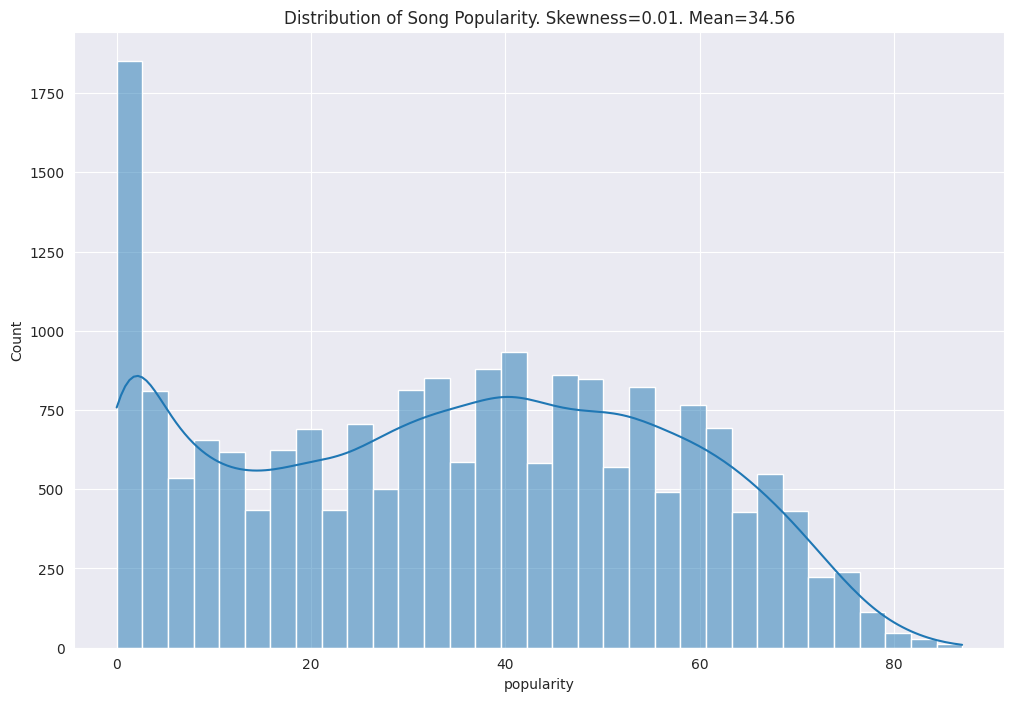

In [26]:
plt.figure(figsize=(12, 8))
sns.histplot(merged_df['popularity'], kde=True)
plt.title(f"Distribution of Song Popularity. Skewness={skewness_popularity}. Mean={mean_popularity}")
plt.show()

We can infer the following from the histogram:
- The tallest bar on the far left indicate a high count of songs with low popularity scores (close to 0). This show that while many songs are produced, only a small fraction achieve high popularity.
- The mean (average) popularity score is 34.55. This suggests that, on average, songs have a popularity score around 34.55.
- The skewness value of 0.01 indicates that the distribution of song popularity is fairly symmetrical around its mean.

### 5.2. Artists with most solo songs

In [27]:
solo_songs = merged_df.query('song_type == "Solo"')

In [28]:
# Count occurrences of each artist
top_artists = solo_songs['cleaned_artists'].value_counts().head(10).sort_values(ascending=True)

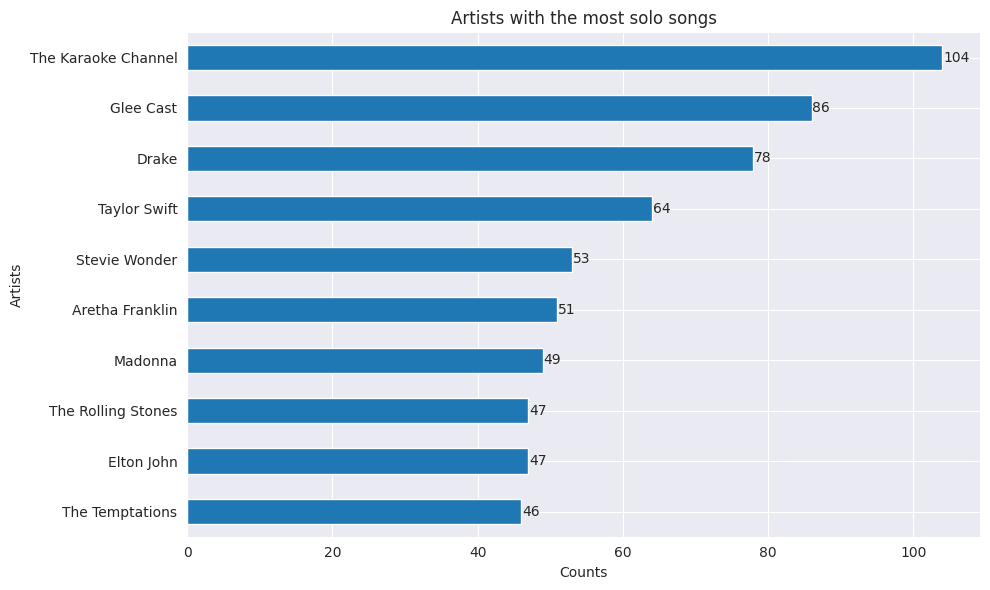

In [29]:
plt.figure(figsize=(10, 6))
bars = top_artists.plot(kind='barh')

# Adding counts at the top of each bar
for i, v in enumerate(top_artists):
    plt.text(v + 0.1, i, str(v), ha='left', va='center')  # Adjust the +0.1 for better positioning

plt.title('Artists with the most solo songs')
plt.ylabel('Artists')
plt.xlabel('Counts')
plt.tight_layout()
plt.show()

The Karaoke Channel have the highest number of solo songs (104), followed closely by Glee Cast with 86 and Drake with 78. Other notable artists include Taylor Swift, Stevie Wonder, and Aretha Franklin, each having 64, 53, and 51 solo songs respectively.

### 5.3. Songs with the Highest Popularity

In [30]:
top_10 = merged_df.sort_values(by='popularity', ascending=False).head(10)

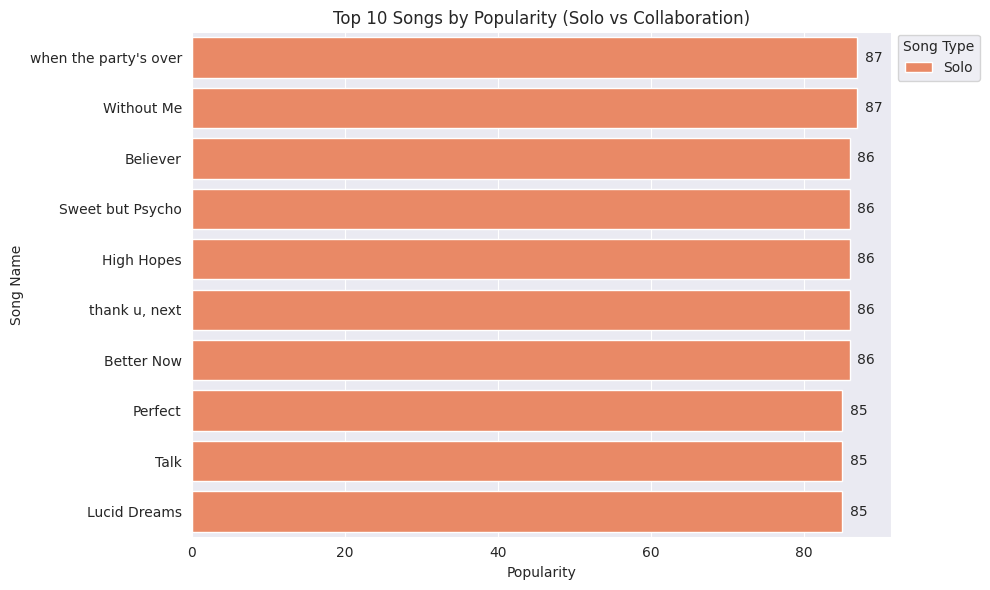

In [31]:
plt.figure(figsize=(10, 6))

palette = {'Solo': 'coral', 'Collaboration': 'orange'}
sns.barplot(x='popularity', y='song_name', data=top_10, hue='song_type', dodge=False, palette=palette)

# Adding counts at the top of each bar
for index, value in enumerate(top_10['popularity']):
    plt.text(value + 1, index, str(value), ha='left', va='center', fontsize=10)

# Shift legend outside of plot
plt.legend(title='Song Type', loc='center left', bbox_to_anchor=(1, 0.95))

plt.xlabel('Popularity')
plt.ylabel('Song Name')
plt.title('Top 10 Songs by Popularity (Solo vs Collaboration)')
plt.tight_layout()
plt.show()

“Without Me” by Halsey and “When the Party’s Over” by Billie Eilish share the top spot as the two most popular songs. Additionally, the fact that the top 10 songs are all solo tracks implies that solo songs have a higher likelihood of becoming hits compared to collaborative ones. 🎵🌟

### 5.4. WordCloud of song lyrics

In [32]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19630 entries, 0 to 19662
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   song_id          19630 non-null  object
 1   song_name        19630 non-null  object
 2   billboard        19630 non-null  object
 3   artists          19630 non-null  object
 4   popularity       19630 non-null  int64 
 5   explicit         19630 non-null  bool  
 6   song_type        19630 non-null  object
 7   lyrics           19630 non-null  object
 8   cleaned_artists  19630 non-null  object
 9   cleaned_lyrics   19630 non-null  object
dtypes: bool(1), int64(1), object(8)
memory usage: 1.5+ MB


In [33]:
all_text = ' '.join(merged_df['cleaned_lyrics'])

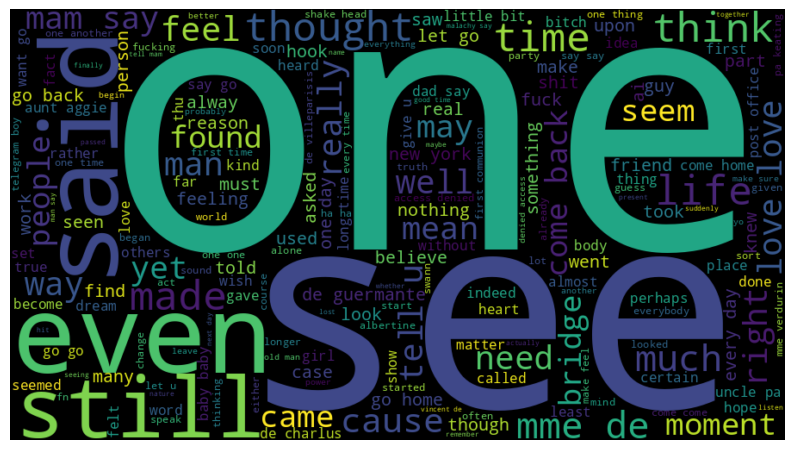

In [34]:
wordcloud = WordCloud(width=900, height=500, background_color='black', random_state=42).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 6. Sentiment Analysis

Before proceeding, here are some business questions I aim to answer 

- Artist Sentiment Trend: What is the overall sentiment of songs by a particular artist? Is there a trend towards more positive or negative sentiment over time?

- Song Sentiment vs. Popularity: Is there a correlation between the sentiment of song lyrics and their popularity? Do more positive songs tend to be more popular? 

- Explicit Content and Sentiment: How does the sentiment of explicit songs compare to non-explicit songs? Are explicit songs generally more negative or positive?

- Sentiment by Song Type: Does the sentiment differ significantly between solo performances and collaborations (duets, groups)?

- Comparing Sentiment Across Artists: How do different artists compare in terms of the sentiment of their song lyrics? Are some artists consistently more positive or negative?

- Extreme Values: Which songs have the most extreme sentiment scores (both positive and negative)? What might account for these?